In [3]:
### Loading the relevant package  ####
library(xts);library(caret);library(dplyr);library(zoo)
library(tidyverse);library(lubridate);library(data.table)
library(ggplot2);library(timeDate);library(Metrics);
library(hydroGOF);library(imputeTS);library(readxl);library(forecastML)

In [4]:
## Data loading and cleaning  ##
## Reading the excel file, starting with 12 line and giving NA as None value
df <- read_xlsx('Data/Anand_Vihar_16_21.xlsx',skip = 12,na = "None")
## converting date into proper date format and selecting the relevant variable needed
df <- df %>% mutate(date = dmy_hm(`From Date`,tz="Asia/Kolkata"),PM25=`PM2.5`)%>%
select(date,PM25,AT,RH,WS,SR,WD)
head(df)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,376.00,11.43,69.00,0.30,12.25,216.25
2016-01-01 02:00:00,480.50,11.28,71.50,0.35,12.58,230.92
2016-01-01 03:00:00,486.67,11.71,71.83,0.31,12.33,203.25
2016-01-01 04:00:00,441.17,11.13,73.08,0.30,12.75,126.92
2016-01-01 05:00:00,594.83,11.01,74.75,0.30,12.58,196.42
2016-01-01 06:00:00,441.33,11.49,74.17,0.37,13.83,80.58


In [5]:
## Converting the data into daily time series
hourly_df <- df %>%
  select(date, PM25) %>% # to check the model for PM2.5 replace PM2.5 by PM2.5
  # extract date features
  mutate(
    date = as.POSIXct(date, format = "%d-%m-%Y %H:%M"), #Date format
    hour = hour(date),
    day = day(date),
    month = month(date),
    year = year(date),
    PM2.5 = ifelse(PM25 <5 | PM25 >999 ,NA,PM25) ## Removing PM2.5 less than 5 and 999 
  ) %>%
  # from hourly to daily
  group_by(date,hour, day, month, year) %>% ## Use if in case one want to convert to daily, monthly
  summarise(PM25 = mean(PM2.5, na.rm = TRUE)) %>% ## 
  mutate(week = week(date))

## Putting NA if there are null values 
hourly_df$PM25[is.nan(hourly_df$PM25)] <- NA
head(hourly_df)

`summarise()` has grouped output by 'date', 'hour', 'day', 'month'. You can override using the `.groups` argument.



date,hour,day,month,year,PM25,week
<dttm>,<int>,<int>,<int>,<int>,<dbl>,<int>
2016-01-01 01:00:00,1,1,1,2016,376.00,1
2016-01-01 02:00:00,2,1,1,2016,480.50,1
2016-01-01 03:00:00,3,1,1,2016,486.67,1
2016-01-01 04:00:00,4,1,1,2016,441.17,1
2016-01-01 05:00:00,5,1,1,2016,594.83,1
2016-01-01 06:00:00,6,1,1,2016,441.33,1


In [6]:
######################## Seasonal Indexes #####################################

## We creating index of seasons from the data till 2020 end

seasonalIndex <- hourly_df %>% filter(date < as.Date("2021-1-01"))


############################### Hourly seasonality  #######################
hourly_s <- seasonalIndex %>% group_by(year, month, day,hour) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

hourly_s$average[is.nan(hourly_s$average)] <- NA

## Spanning the year wise value column wise
hourly_s <- hourly_s %>% ungroup() %>%
  spread(year, average)
head(hourly_s)

# Calcuating the mean hourly index over the years (Except first, second and third columns)
hourly_s$meanindex <- rowMeans(hourly_s[, -c(1,2,3)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- hourly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
hourly_s <- merge(hourly_s, summary_mean)

## Finally calculating the hourly index by mean index/ summary mean * 100
hourly_s <-
  hourly_s %>% mutate(hourlyindex = meanindex / summary_mean * 100)

head(hourly_s)


`summarise()` has grouped output by 'year', 'month', 'day'. You can override using the `.groups` argument.



month,day,hour,2016,2017,2018,2019,2020
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0,NA,162.00,754,517.25,857.50
1,1,1,376.00,165.17,754,531.25,472.75
1,1,2,480.50,176.67,868,542.00,384.75
1,1,3,486.67,150.67,854,547.50,334.50
1,1,4,441.17,129.50,713,497.00,362.75
1,1,5,594.83,145.00,625,467.50,403.25


,month,day,hour,2016,2017,2018,2019,2020,meanindex,summary_mean,hourlyindex
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0,NA,162.00,754,517.25,857.50,572.6875,139.2944,411.1348
2,1,1,1,376.00,165.17,754,531.25,472.75,459.8340,139.2944,330.1168
3,1,1,2,480.50,176.67,868,542.00,384.75,490.3840,139.2944,352.0487
4,1,1,3,486.67,150.67,854,547.50,334.50,474.6680,139.2944,340.7661
5,1,1,4,441.17,129.50,713,497.00,362.75,428.6840,139.2944,307.7540
6,1,1,5,594.83,145.00,625,467.50,403.25,447.1160,139.2944,320.9865


`summarise()` has grouped output by 'year', 'month'. You can override using the `.groups` argument.



month,day,2016,2017,2018,2019,2020
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,359.5730,199.8817,481.6250,380.2292,367.3750
1,2,327.9150,257.1204,359.6667,418.4688,361.6875
1,3,341.3188,271.6446,287.7083,412.8854,378.6765
1,4,480.0688,270.1217,351.6250,291.9479,216.5625
1,5,433.3537,246.8504,306.2500,241.6667,190.5938
1,6,371.7995,189.3525,324.7500,191.8542,166.8646


,month,day,2016,2017,2018,2019,2020,meanindex,summary_mean,dailyindex
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,359.5730,199.8817,481.6250,380.2292,367.3750,357.7368,139.0868,257.2039
2,1,2,327.9150,257.1204,359.6667,418.4688,361.6875,344.9717,139.0868,248.0261
3,1,3,341.3188,271.6446,287.7083,412.8854,378.6765,338.4467,139.0868,243.3348
4,1,4,480.0688,270.1217,351.6250,291.9479,216.5625,322.0652,139.0868,231.5569
5,1,5,433.3537,246.8504,306.2500,241.6667,190.5938,283.7429,139.0868,204.0041
6,1,6,371.7995,189.3525,324.7500,191.8542,166.8646,248.9242,139.0868,178.9703


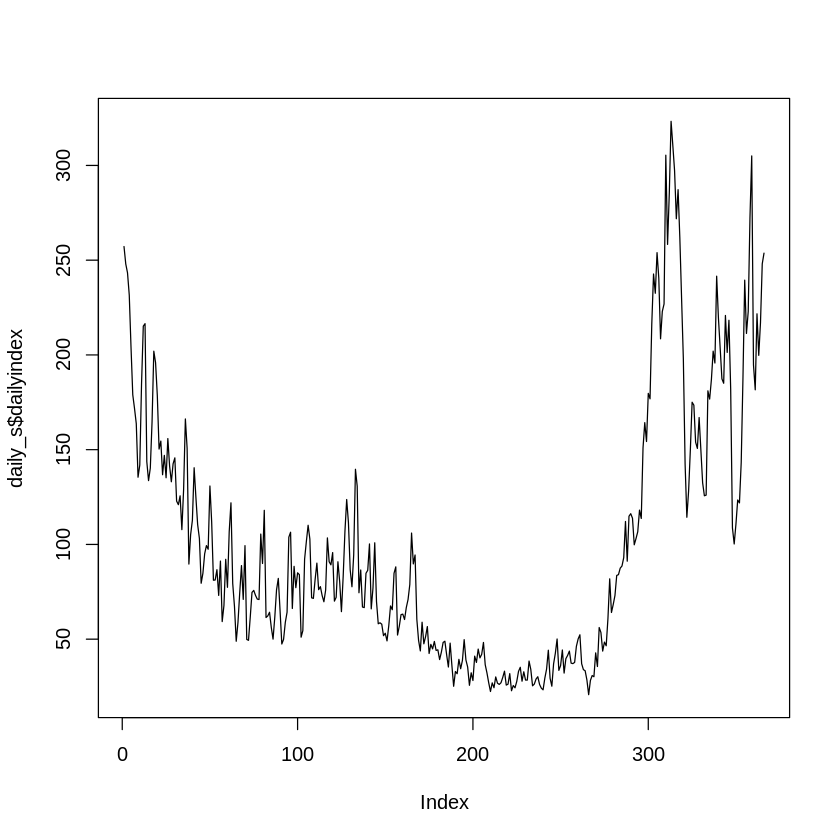

In [7]:
############################### daily seasonality  #######################
daily_s <- seasonalIndex %>% group_by(year, month, day) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

daily_s$average[is.nan(daily_s$average)] <- NA

## Spanning the year wise value column wise
daily_s <- daily_s %>% ungroup() %>%
  spread(year, average)
head(daily_s)

# Calcuating the mean daily index over the years (Except first and second columns)
daily_s$meanindex <- rowMeans(daily_s[, -c(1,2)], na.rm = TRUE)

## Summary mean is the mean of Mean index
summary_mean <- daily_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## We merge the Summary mean with our old data frame 
daily_s <- merge(daily_s, summary_mean)

## Finally calculating the daily index by mean index/ summary mean * 100
daily_s <-
  daily_s %>% mutate(dailyindex = meanindex / summary_mean * 100)

head(daily_s)
plot(daily_s$dailyindex,type="l")

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



week,2016,2017,2018,2019,2020
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,386.0533,239.1619,351.9375,322.8420,278.9070
2,348.5349,169.6000,267.3865,259.8899,179.3212
3,250.1298,162.1944,298.8579,283.6310,148.1811
4,324.5103,167.0156,204.7348,118.1771,200.7925
5,348.7608,178.0511,169.1964,189.1205,109.1730
6,208.5622,151.1387,193.1677,157.0849,157.4178


,week,2016,2017,2018,2019,2020,meanindex,summary_mean,weeklyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,386.0533,239.1619,351.9375,322.8420,278.9070,315.7803,143.5015,220.0537
2,2,348.5349,169.6000,267.3865,259.8899,179.3212,244.9465,143.5015,170.6927
3,3,250.1298,162.1944,298.8579,283.6310,148.1811,228.5988,143.5015,159.3007
4,4,324.5103,167.0156,204.7348,118.1771,200.7925,203.0461,143.5015,141.4941
5,5,348.7608,178.0511,169.1964,189.1205,109.1730,198.8604,143.5015,138.5772
6,6,208.5622,151.1387,193.1677,157.0849,157.4178,173.4742,143.5015,120.8867


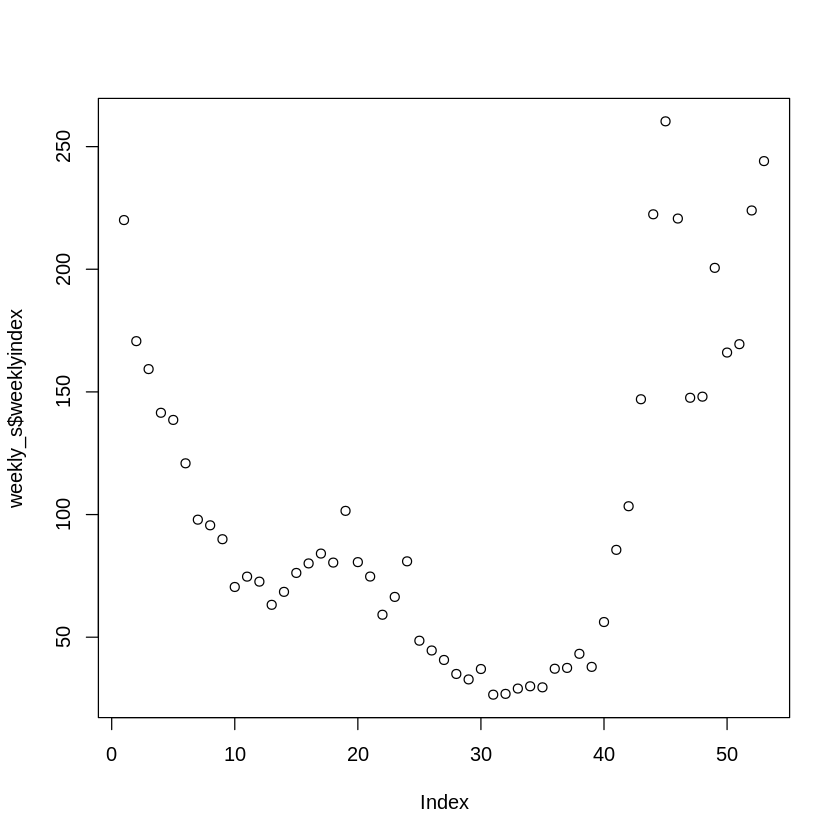

In [8]:
############################### weekly seasonality ###########
weekly_s <- seasonalIndex %>%
  group_by(year, week) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## NA if the average in null
weekly_s$average[is.nan(weekly_s$average)] <- NA

## Spreading across weeks
weekly_s <- weekly_s %>% ungroup() %>%
  spread(year, average)

head(weekly_s)

# Calcuating the mean weekly index over the years
weekly_s$meanindex <- rowMeans(weekly_s[, -1], na.rm = TRUE)

## Calculting summary means
summary_mean <- weekly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Adding summary mean
weekly_s <- merge(weekly_s, summary_mean)

## Calculating weekly index
weekly_s <-
  weekly_s %>% mutate(weeklyindex = meanindex / summary_mean * 100)

head(weekly_s)
plot(weekly_s$weeklyindex)

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



month,2016,2017,2018,2019,2020
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,328.74805,182.4179,268.9588,235.80948,183.39218
2,173.69855,141.0615,161.1128,140.30696,124.65472
3,118.47378,114.2224,120.0038,101.89716,64.33173
4,157.07917,129.8789,116.7254,98.04951,47.21875
5,99.84961,151.1865,106.2613,110.90099,72.89104
6,93.00049,105.8256,116.8000,73.57828,64.95588


,month,2016,2017,2018,2019,2020,meanindex,summary_mean,monthlyindex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,328.74805,182.4179,268.9588,235.80948,183.39218,239.86529,141.5354,169.47377
2,2,173.69855,141.0615,161.1128,140.30696,124.65472,148.16691,141.5354,104.68545
3,3,118.47378,114.2224,120.0038,101.89716,64.33173,103.78577,141.5354,73.32852
4,4,157.07917,129.8789,116.7254,98.04951,47.21875,109.79034,141.5354,77.57097
5,5,99.84961,151.1865,106.2613,110.90099,72.89104,108.21789,141.5354,76.45998
6,6,93.00049,105.8256,116.8000,73.57828,64.95588,90.83205,141.5354,64.17623


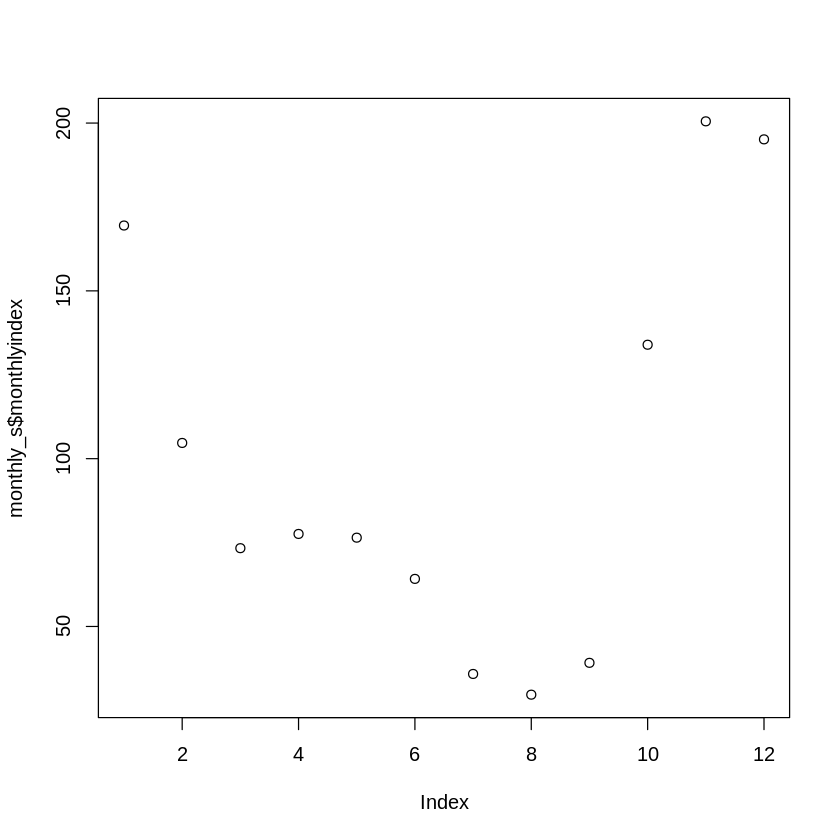

In [9]:
############################### monthly seasonality ##############################

## Grouping by year and month
monthly_s <- seasonalIndex %>%
  group_by(year, month) %>%
  summarize(average = mean(PM25, na.rm = TRUE))

## Adding NA values if there are any null values of any sort 
monthly_s$average[is.nan(monthly_s$average)] <- NA

## Spreading across months 
monthly_s <- monthly_s %>% ungroup() %>%
  spread(year, average)

head(monthly_s)

# Calcuating the mean weekly index over the years (-1 to remove first column which is month)
monthly_s$meanindex <- rowMeans(monthly_s[, -1], na.rm = TRUE)

## Summary mean of the mean index
summary_mean <- monthly_s %>% ungroup() %>%
  summarize(summary_mean = mean(meanindex, na.rm = T))

## Merging the summary mean with the data frame
monthly_s <- merge(monthly_s, summary_mean)

## Adding the Monthly index
monthly_s <-
  monthly_s %>% mutate(monthlyindex = meanindex / summary_mean * 100)
head(monthly_s)
plot(monthly_s$monthlyindex)

In [10]:
############# Join the indexes to original houly data

hourly_s <- hourly_s %>% select(month,day,hour,hourlyindex)
hourly_df <- hourly_df %>% left_join(hourly_s,by=c("month","day","hour"))

daily_s <- daily_s %>% select(month, day, dailyindex)
hourly_df <- hourly_df %>% left_join(daily_s, by = c("month", "day"))

monthly_s <- monthly_s %>% select(month, monthlyindex)
hourly_df <- hourly_df %>% left_join(monthly_s, by = c("month"))

weekly_s <- weekly_s %>% select(week, weeklyindex)
hourly_df <- hourly_df %>% left_join(weekly_s, by = c("week"))

head(hourly_df)
## Removing the unnecessary data frames 
#rm(hourly_s)
#rm(daily_s)
#rm(monthly_s)
#rm(weekly_s)
rm(summary_mean)
rm(seasonalIndex)


date,hour,day,month,year,PM25,week,hourlyindex,dailyindex,monthlyindex,weeklyindex
<dttm>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2016-01-01 01:00:00,1,1,1,2016,376.00,1,330.1168,257.2039,169.4738,220.0537
2016-01-01 02:00:00,2,1,1,2016,480.50,1,352.0487,257.2039,169.4738,220.0537
2016-01-01 03:00:00,3,1,1,2016,486.67,1,340.7661,257.2039,169.4738,220.0537
2016-01-01 04:00:00,4,1,1,2016,441.17,1,307.7540,257.2039,169.4738,220.0537
2016-01-01 05:00:00,5,1,1,2016,594.83,1,320.9865,257.2039,169.4738,220.0537
2016-01-01 06:00:00,6,1,1,2016,441.33,1,249.3396,257.2039,169.4738,220.0537


In [11]:
################### Data manipulation using forecastML
## Fill_gaps is a function from forecatML to see if there are missing value it creates
## an evenly spaced data frame
hourly_ts <- fill_gaps(hourly_df, date_col = 1, frequency = "1 hour")

#hourly_ts$date <- NULL
hourly_ts$hour <- NULL
hourly_ts$day <- NULL
hourly_ts$month <- NULL
hourly_ts$week <- NULL
head(hourly_ts)


,date,year,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2016-01-01 01:00:00,2016,376.00,330.1168,257.2039,169.4738,220.0537
2,2016-01-01 02:00:00,2016,480.50,352.0487,257.2039,169.4738,220.0537
3,2016-01-01 03:00:00,2016,486.67,340.7661,257.2039,169.4738,220.0537
4,2016-01-01 04:00:00,2016,441.17,307.7540,257.2039,169.4738,220.0537
5,2016-01-01 05:00:00,2016,594.83,320.9865,257.2039,169.4738,220.0537
6,2016-01-01 06:00:00,2016,441.33,249.3396,257.2039,169.4738,220.0537


In [62]:
## For the training per se we will try to train the model from 2019/2020 onwards, we are also filling the missing value using moving average of last 48 hour
hourly_ts_filtered <- hourly_ts %>% filter(date>=ymd("2020-01-01"))%>%na_ma(k=48,weighting = "simple")
dates <- hourly_ts_filtered$date
head(hourly_ts_filtered)

,date,year,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-01-01 00:00:00,2020,857.50,411.1348,257.2039,169.4738,220.0537
2,2020-01-01 01:00:00,2020,472.75,330.1168,257.2039,169.4738,220.0537
3,2020-01-01 02:00:00,2020,384.75,352.0487,257.2039,169.4738,220.0537
4,2020-01-01 03:00:00,2020,334.50,340.7661,257.2039,169.4738,220.0537
5,2020-01-01 04:00:00,2020,362.75,307.7540,257.2039,169.4738,220.0537
6,2020-01-01 05:00:00,2020,403.25,320.9865,257.2039,169.4738,220.0537


In [63]:
## Training data is all the dates before 2021
data_train <- hourly_ts_filtered %>% filter(date <ymd('2021-01-10'))
## Testing data data is the dates after 2021
data_test <- hourly_ts_filtered %>% filter(date >ymd('2021-01-10'))
head(data_test)

,date,year,PM25,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2021-01-10 01:00:00,2021,146.00,143.0668,141.8823,169.4738,170.6927
2,2021-01-10 02:00:00,2021,136.25,138.8068,141.8823,169.4738,170.6927
3,2021-01-10 03:00:00,2021,144.75,141.0926,141.8823,169.4738,170.6927
4,2021-01-10 04:00:00,2021,145.50,138.2095,141.8823,169.4738,170.6927
5,2021-01-10 05:00:00,2021,129.50,142.1206,141.8823,169.4738,170.6927
6,2021-01-10 06:00:00,2021,117.50,142.8945,141.8823,169.4738,170.6927


In [64]:
horizons <- c(1, 3, 6, 12,24)
lookback <- c(1:6,12, 24,48)
#dates <- data_train$date
## Now creating a training data frame with lookback of 12 hours 
data_train_lagged <-
  create_lagged_df(
    data_train, ## data frame
    type = "train", ## training 
    outcome_col = 3,## Output column is PM2.5 
    horizons = horizons, ## Horizons is used if you want to predict for more than one hour
    date = dates[1:nrow(data_train)],
    lookback = lookback,## Lookback of x hour
    dynamic_features = c("year","hourlyindex", "dailyindex", "monthlyindex", "weeklyindex","date"), ## dynamic features of index
    frequency = "1 hour" ## Frequency is 1 day
  )


In [65]:
head(data_train_lagged$horizon_24)
#plot(data_train_lagged)

,PM25,PM25_lag_24,PM25_lag_48,date,year,hourlyindex,dailyindex,monthlyindex,weeklyindex
,<dbl>,<dbl>,<dbl>,<dttm>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
49,766.50,445.00,857.50,2020-01-03 00:00:00,2020,343.5143,243.3348,169.4738,220.0537
50,775.00,356.25,472.75,2020-01-03 01:00:00,2020,323.2364,243.3348,169.4738,220.0537
51,641.25,358.25,384.75,2020-01-03 02:00:00,2020,299.0789,243.3348,169.4738,220.0537
52,597.50,381.25,334.50,2020-01-03 03:00:00,2020,304.2593,243.3348,169.4738,220.0537
53,541.50,378.50,362.75,2020-01-03 04:00:00,2020,275.9509,243.3348,169.4738,220.0537
54,484.50,367.75,403.25,2020-01-03 05:00:00,2020,252.8746,243.3348,169.4738,220.0537


In [66]:
windows <- forecastML::create_windows(lagged_df = data_train_lagged, window_length = 240, skip = 360,
                                      window_start = NULL, window_stop = NULL,
                                      include_partial_window = TRUE)
windows

,start,stop,window_length
,<dttm>,<dttm>,<dbl>
1,2020-01-03,2020-01-12 23:00:00,240
2,2020-01-28,2020-02-06 23:00:00,240
3,2020-02-22,2020-03-02 23:00:00,240
4,2020-03-18,2020-03-27 23:00:00,240
5,2020-04-12,2020-04-21 23:00:00,240
6,2020-05-07,2020-05-16 23:00:00,240
7,2020-06-01,2020-06-10 23:00:00,240
8,2020-06-26,2020-07-05 23:00:00,240
9,2020-07-21,2020-07-30 23:00:00,240


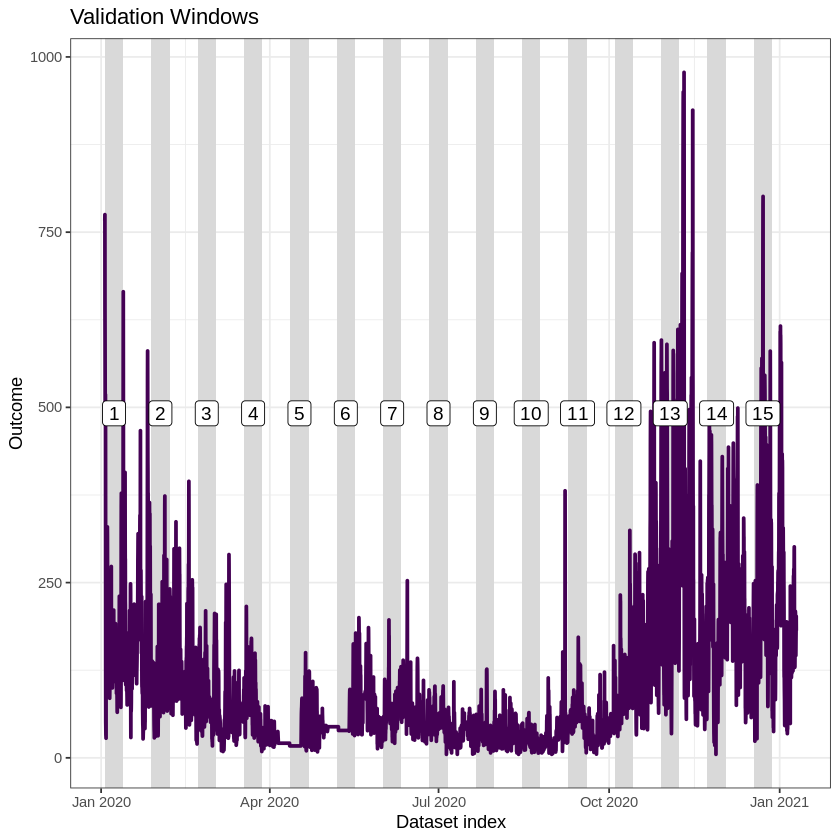

In [67]:
plot(windows, data_train_lagged,show_labels = TRUE)

In [68]:
start <- Sys.time()
#------------------------------------------------------------------------------
# User-define model - Linear Regression
model_function_LinReg <- function(data) {
  dep_variable <- "PM25"
  ## Removing all date, year and PM2.5 from the independent variables name
  ind_variables <- setdiff(names(data),c("date","year","PM25"))
  model_formula <- as.formula(paste(dep_variable,paste(ind_variables,collapse="+"),sep=" ~ "))
  model <- lm(model_formula, data = data) ## Linear model in this case
  return(model)
}


In [69]:

# Example 2 - Random Forest
# Alternatively, we could define an outcome column identifier argument, say, 'outcome_col = 1' in 
# this function or just 'outcome_col' and then set the argument as 'outcome_col = 1' in train_model().
model_function_2 <- function(data) {
  dep_variable <- "PM25"
  ind_variables <- setdiff(names(data),c("date","year","PM25"))
  model_formula <- as.formula(paste(dep_variable,paste(ind_variables,collapse="+"),sep=" ~ "))
  model <- randomForest::randomForest(formula = model_formula, data = data, ntree = 200)
  return(model)
}

In [70]:
model_results_LinReg <- forecastML::train_model(
  data_train_lagged, ## Training data
  windows = windows, ## The windows
  model_name = "LinReg", ## Linear Regressing
  model_function = model_function_LinReg, ## The model function
  use_future = FALSE 
)
end <- Sys.time()
end-start

Time difference of 4.60621 secs

In [ ]:
model_results_RF <- forecastML::train_model(
    data_train_lagged,
    windows=windows, 
    model_name = "RF", 
    model_function = model_function_2, 
    use_future = FALSE)
end <- Sys.time()
end-start

In [ ]:
## Defining the prediction function (Linear model)
prediction_function <- function(model, data_features) {
  data_pred <- data.frame("y_pred" = predict(model, data_features))
  return(data_pred)
}



In [ ]:
data_results <- predict(model_results_LinReg, model_results_RF,
                        prediction_function = list(prediction_function, prediction_function), 
                        data = data_train_lagged)

In [ ]:
plot(data_results, type = "prediction", horizons = c(1, 12,24))

In [ ]:
data_error <- forecastML::return_error(data_results)
head(data_error)

In [ ]:
plot(data_results, type = "residual", horizons = c(1, 6, 12,24))

In [ ]:
plot(data_error, type = "horizon", facet = ~ horizon, horizons = c(1, 6, 12,24))


In [ ]:
plot(data_error, type = "global", facet = ~ horizon)

In [ ]:
data_results %>% group_by(model,model_forecast_horizon)%>% summarize(R2=R2(PM25,PM25_pred),RMSE=RMSE(PM25,PM25_pred),
                                                                    MAE=MAE(PM25,PM25_pred),MAPE=mape(PM25,PM25_pred))

In [55]:
#jpeg("Images/Model_comparison_training.jpeg", units="cm", width=36, height=15,res = 300)
#plot(data_error, type = "window", facet = ~ horizon, horizons = c(1, 6,12,24))
#dev.off()

png 
  2

In [ ]:
horizons <- c(1, 3, 6, 12,24)
lookback <- c(1:6,12, 24,48)

data_forecast_list <- forecastML::create_lagged_df(data_train,
                                                   outcome_col = 3,
                                                   type = "forecast",
                                                   horizons = horizons,
                                                   lookback=lookback,
                                                   date = dates[1:nrow(data_train)],
                                                   frequency = "1 hour",
                                                   dynamic_features = c("year","hourlyindex", "dailyindex", "monthlyindex", "weeklyindex","date"), ## dynamic features of index
                                                   
                                                   )

In [ ]:
dynamic_features <- c("hourlyindex", "dailyindex", "monthlyindex", "weeklyindex","date")
## This merge data is created to merge indexes and we are removing unnecessary columns 
merge_data <- hourly_df%>%ungroup(date)%>%select(-c(date,year,PM25))
for (i in seq_along(data_forecast_list)) {
    ## Adding date in the data frame horizons
  data_forecast_list[[i]]$date <-data_forecast_list[[i]]$index
  ##  Now adding the indexes from the merge data frame 
  data_forecast_list[[i]] <- data_forecast_list[[i]] %>%
    mutate(hour = hour(date),
    day = day(date),week = week(date),
    month = month(date),
    year = year(date)) %>%select(-dynamic_features)%>% ## First we need to remove these existing features
    left_join(merge_data,by=c("hour","day","week","month"))%>% ## Now we adding these features back using merge data frame 
    select(-c("hour","day","week","month"))%>%distinct()
    
}
rm(merge_data)
tail(data_forecast_list$horizon_1)

In [ ]:
data_forecast <- predict(model_results_LinReg, model_results_RF,  # ... supports any number of ML models.
                         prediction_function = list(prediction_function, prediction_function), 
                         data = data_forecast_list)

In [ ]:
head(data_forecast)
head(data_test)

In [ ]:
plot(data_forecast,
     data_actual = hourly_ts_filtered[-(1:360), ],  # Actuals from the training and test data sets.
     actual_indices = dates[-(1:360)], 
     horizons = c(1, 6, 12))

In [ ]:
data_error <- forecastML::return_error(data_forecast,
                                       data_test = data_test,
                                       test_indices = dates[(nrow(data_train) + 2):length(dates)])

plot(data_error, facet = ~ horizon, type = "horizon")

In [ ]:
plot(data_error, facet = ~ horizon, type = "global")

In [ ]:
plot(data_results, type = "prediction", horizons = c(1, 6, 12))

In [48]:
head(df %>% filter(date >ymd("2021-01-15")),50)

date,PM25,AT,RH,WS,SR,WD
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-15 01:00:00,NA,13.10,94.72,0.30,9.00,169.25
2021-01-15 02:00:00,879.00,13.10,94.95,0.30,8.95,102.75
2021-01-15 03:00:00,855.00,13.00,95.25,0.30,9.00,90.50
2021-01-15 04:00:00,783.00,12.88,95.38,0.30,9.00,63.50
2021-01-15 05:00:00,460.00,12.67,95.17,0.30,8.95,71.50
2021-01-15 06:00:00,449.75,12.65,95.18,0.30,9.03,107.25
2021-01-15 07:00:00,435.25,12.68,95.38,0.30,43.45,114.25
2021-01-15 08:00:00,499.25,13.25,94.17,0.30,151.55,88.25
2021-01-15 09:00:00,567.25,14.12,89.30,0.32,292.62,102.00
